In [ ]:
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import folium
import matplotlib.colors as mcolors
import scipy.stats as stats

In [ ]:
df=pd.read_csv('region_df.csv').drop(columns='Unnamed: 0')

In [ ]:
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율
0,종로구,41.46,9.95,23.99,0,서울특별시,116.49,85.6,13.45,0.001464
1,중구,77.21,7.71,9.99,0,서울특별시,116.49,85.6,13.45,0.001464
2,용산구,48.26,10.57,21.89,0,서울특별시,116.49,85.6,13.45,0.001464
3,성동구,64.81,10.90,16.82,0,서울특별시,116.49,85.6,13.45,0.001464
4,광진구,63.49,10.82,17.05,0,서울특별시,116.49,85.6,13.45,0.001464


##Preprocessing

In [ ]:
# '행정구역면적(㎢)' 컬럼의 값을 float로 변환
df['행정구역면적(㎢)'] = df['행정구역면적(㎢)'].str.replace(',', '')  # 쉼표 제거
df['행정구역면적(㎢)'] = df['행정구역면적(㎢)'].astype(float)  # float로 변환

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일링
scaler = MinMaxScaler()
scaling_columns = ['불투수면 비율(%)', '불투수면 면적(㎢)', '행정구역면적(㎢)', '농업면적',
                   '농가인구비율', '연평균강수량', '해발고도', '연평균기온']

df[scaling_columns] = scaler.fit_transform(df[scaling_columns])
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율
0,종로구,0.482083,0.045114,0.011554,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
1,중구,0.911977,0.031476,0.003840,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
2,용산구,0.563853,0.048889,0.010397,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
3,성동구,0.762867,0.050898,0.007604,0.0,서울특별시,0.294639,0.105457,0.601286,0.0
4,광진구,0.746994,0.050411,0.007731,0.0,서울특별시,0.294639,0.105457,0.601286,0.0


##Truncated SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_sparse_coded_signal

X = df[[col for col in df.columns if col != '시도시군구']].copy()
X = X[[col for col in X.columns if col != '시도구분']].copy()

# Truncated SVD 모델 생성
n_components = 2  # 축소할 차원 수
svd = TruncatedSVD(n_components=n_components, random_state=42)

# 모델 학습 및 변환
X_transformed = svd.fit_transform(X)

# 결과 확인
print(f"원래 데이터 차원: {X.shape}")
print(f"축소된 데이터 차원: {X_transformed.shape}")


원래 데이터 차원: (250, 9)
축소된 데이터 차원: (250, 2)


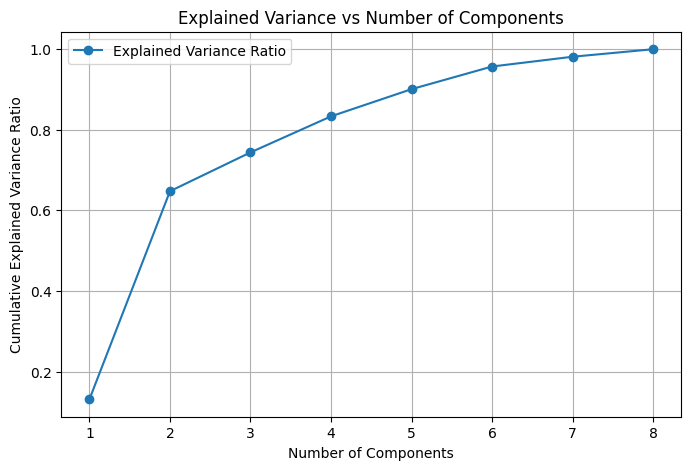

최적의 차원 수: 6


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_sparse_coded_signal
import numpy as np

# 설명된 분산 비율 계산
explained_variance_ratios = []
component_range = range(1, 9)
for n_components in component_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X)
    explained_variance_ratios.append(np.sum(svd.explained_variance_ratio_))

# 최적 차원 찾기 (설명된 분산 비율 기준, 95% 이상)
optimal_dim = next(
    (i + 1 for i, ratio in enumerate(explained_variance_ratios) if ratio >= 0.95), len(component_range)
)

# 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(component_range, explained_variance_ratios, marker='o', label='Explained Variance Ratio')
#plt.axvline(optimal_dim, color='r', linestyle='--', label=f'Optimal Dim: {optimal_dim}')
plt.title("Explained Variance vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.legend()
plt.grid()
plt.show()

print(f"최적의 차원 수: {optimal_dim}")


In [ ]:
# 2차원에서 설명된 분산 비율 계산
singular_values_2d = svd.singular_values_
total_variance_2d = np.sum(svd.singular_values_**2)  # 전체 분산은 원래 SVD 기준으로 동일
explained_variance_ratio_2d = (singular_values_2d**2) / total_variance_2d
cumulative_variance_2d = np.cumsum(explained_variance_ratio_2d)

print("2차원에서 설명된 분산 비율:")
print(explained_variance_ratio_2d)
print("누적 설명된 분산 비율:")
print(cumulative_variance_2d)

2차원에서 설명된 분산 비율:
[0.7456702  0.15234368 0.02790256 0.02587189 0.01949845 0.01627681
 0.00703952 0.00539689]
누적 설명된 분산 비율:
[0.7456702  0.89801388 0.92591644 0.95178834 0.97128678 0.9875636
 0.99460311 1.        ]


In [ ]:
# 컬럼 이름과 주성분 행렬 확인
columns = X.columns
assert len(columns) == svd.components_.shape[1], "컬럼 개수와 주성분 행렬의 열 개수가 맞지 않습니다."

# 주성분 데이터프레임 생성
principal_components = pd.DataFrame(
    svd.components_,
    columns=columns,
    index=[f"Component {i+1}" for i in range(svd.components_.shape[0])]
)

# 결과 출력
print(principal_components)


             불투수면 비율(%)  불투수면 면적(㎢)  행정구역면적(㎢)      농업면적    연평균강수량      해발고도  \
Component 1    0.241776    0.227778   0.261646  0.090984  0.330865  0.145589   
Component 2    0.608821   -0.112032  -0.335140 -0.156881  0.183539  0.092485   
Component 3   -0.076572    0.330461   0.509849  0.554331 -0.035547  0.101461   
Component 4   -0.399713    0.000598   0.155642 -0.444972  0.508473  0.562577   
Component 5   -0.208002    0.599301  -0.014967 -0.464664  0.021254 -0.559009   
Component 6    0.515990    0.241236   0.434807 -0.411666 -0.376157  0.238863   

                연평균기온    농가인구비율  
Component 1  0.658579  0.498529  
Component 2  0.302675 -0.588220  
Component 3  0.047405 -0.551270  
Component 4 -0.093668 -0.184916  
Component 5  0.189090 -0.180937  
Component 6 -0.329050  0.101046  


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

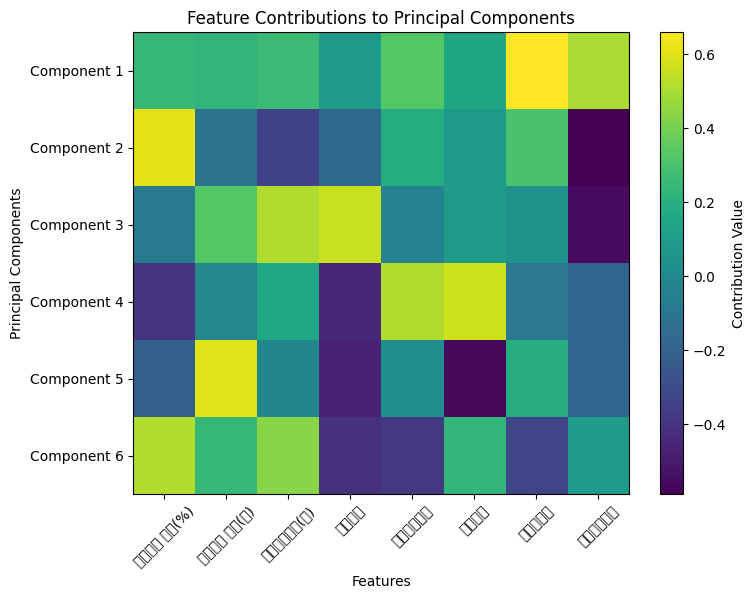

In [ ]:
# Principal components and explained variance
components = principal_components.values
explained_variance = explained_variance_ratio_2d

# Heatmap for component contributions
plt.figure(figsize=(8, 6))
plt.imshow(components, cmap='viridis', aspect='auto')
plt.colorbar(label="Contribution Value")
plt.title("Feature Contributions to Principal Components")
plt.xticks(ticks=np.arange(len(columns)), labels=columns, rotation=45)
plt.yticks(ticks=np.arange(len(components)), labels=[f"Component {i+1}" for i in range(len(components))])
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.show()

##K-means 군집분석

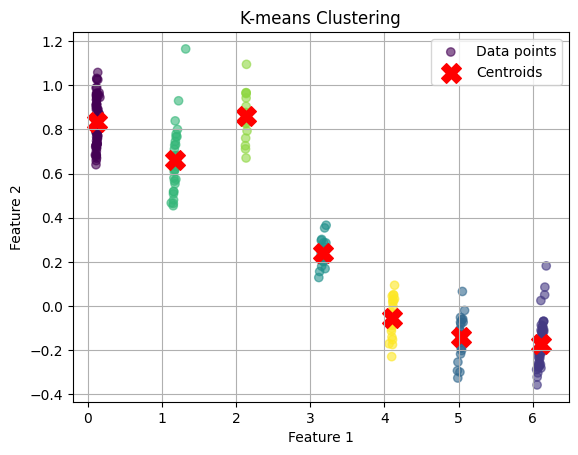

클러스터 중심점:
[[ 0.12186158  0.83204147]
 [ 6.11073856 -0.17005517]
 [ 5.03222348 -0.1407966 ]
 [ 3.17295534  0.23960109]
 [ 1.18104157  0.65938503]
 [ 2.13376144  0.8589446 ]
 [ 4.10791685 -0.05452352]]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# K-means 모델 생성
n_clusters = 7 # 클러스터 개수
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# 데이터 클러스터링
kmeans.fit(X_transformed)
labels = kmeans.labels_  # 각 데이터가 속한 클러스터
centroids = kmeans.cluster_centers_  # 클러스터 중심점

# 결과 시각화
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()

print(f"클러스터 중심점:\n{centroids}")


###최적의 k값 찾기

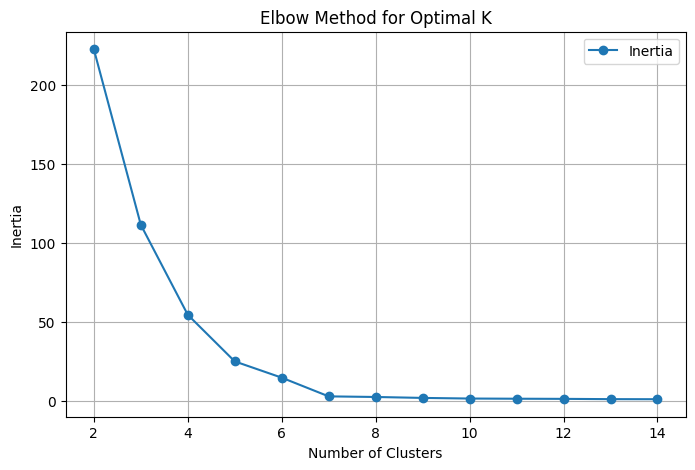

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 엘보우 메소드
inertia = []
silhouette_scores = []
cluster_range = range(2, 15)  # 클러스터 개수 범위

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    inertia.append(kmeans.inertia_)  # 클러스터 내 거리의 합
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))  # 실루엣 계수

# 엘보우 그래프
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.legend()
plt.show()


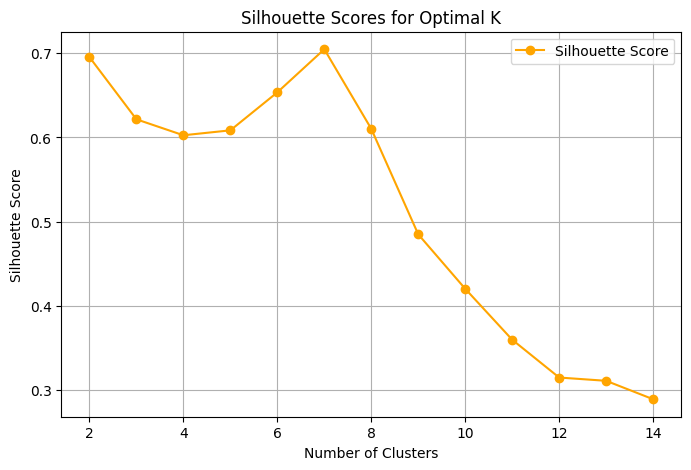

최적 클러스터 개수 (실루엣 기준): 7


In [ ]:
# 실루엣 계수 그래프
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Scores for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.legend()
plt.show()

# 최적 클러스터 개수 출력
optimal_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"최적 클러스터 개수 (실루엣 기준): {optimal_k}")


###clustering 결과

In [ ]:
# 라벨을 df에 cluster 컬럼으로 추가
df['cluster'] = labels
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율,cluster
0,종로구,0.482083,0.045114,0.011554,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
1,중구,0.911977,0.031476,0.003840,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
2,용산구,0.563853,0.048889,0.010397,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
3,성동구,0.762867,0.050898,0.007604,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0
4,광진구,0.746994,0.050411,0.007731,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0


In [ ]:
# 시도구분을 기준으로 cluster 분포 집계
cluster_distribution = df.groupby('시도구분')['cluster'].value_counts().unstack(fill_value=0)
cluster_distribution

cluster,0,1,2,3,4,5,6
시도구분,,,,,,,
강원특별자치도,0,1,0,0,2,0,15
경기도,25,0,17,0,0,0,0
경상남도,0,0,0,3,17,0,2
경상북도,0,10,0,11,0,0,2
광주광역시,4,0,1,0,0,0,0
대구광역시,6,0,3,0,0,0,0
대전광역시,3,0,2,0,0,0,0
부산광역시,0,0,0,0,0,16,0
서울특별시,25,0,0,0,0,0,0


In [ ]:
# 각 클러스터에 포함된 데이터 개수 계산
cluster_counts = np.bincount(labels)

# 결과 출력
for cluster_id, count in enumerate(cluster_counts):
    print(f"클러스터 {cluster_id}: {count}개")

클러스터 0: 74개
클러스터 1: 51개
클러스터 2: 28개
클러스터 3: 20개
클러스터 4: 34개
클러스터 5: 16개
클러스터 6: 27개


In [ ]:
#클러스터 별 컬럼 특징 확인
X['cluster'] = labels
grouped = pd.DataFrame(X.groupby('cluster').agg(['mean', 'std']))
grouped

불투수면 비율(%)           불투수면 면적(㎢)           행정구역면적(㎢)            \
              mean       std       mean       std      mean       std   
cluster                                                                 
0         0.523818  0.198752   0.090415  0.058749  0.023457  0.017509   
1         0.101680  0.072258   0.294174  0.131227  0.320262  0.134338   
2         0.145778  0.070929   0.317134  0.194367  0.249195  0.133184   
3         0.048130  0.029199   0.271732  0.113848  0.495841  0.118917   
4         0.141938  0.088505   0.219105  0.148638  0.191118  0.116776   
5         0.523073  0.227392   0.071587  0.075310  0.025387  0.034626   
6         0.029626  0.018078   0.179676  0.076168  0.492634  0.189304   

             농업면적              연평균강수량                해발고도               연평균기온  \
             mean       std      mean       std      mean       std      mean   
cluster                                                                         
0        0.000895  0.004113  0.251963  0.086633  0.090148  0.015765  0.605255   
1        0.040642  0.089203  0.290073  0.102769  0.090030  0.063820  0.623364   
2        0.073594  0.135330  0.248881  0.096989  0.087353  0.018060  0.573228   
3        0.561763  0.181521  0.207830  0.100497  0.088523  0.050940  0.598136   
4        0.057695  0.102926  0.398436  0.178293  0.057614  0.028084  0.672697   
5        0.000000  0.000000  0.618426  0.000000  0.507261  0.000000  0.822079   
6        0.032852  0.082011  0.254519  0.090245  0.307751  0.204891  0.418320   

                     농가인구비율            
              std      mean       std  
cluster                                
0        0.071919  0.072100  0.057425  
1        0.094241  0.849175  0.139402  
2        0.091505  0.119073  0.030397  
3        0.069745  0.725636  0.177437  
4        0.096662  0.520261  0.089521  
5        0.000000  0.036075  0.000000  
6        0.119721  0.610934  0.088934

In [ ]:
df.to_csv('군집분석_완료_df(1).csv')

In [ ]:
#군집분석 한 결과 시도별로 나누기
df=pd.read_csv('region_clustering.csv').drop(columns='Unnamed: 0')
pd.crosstab(df['시도구분'], df['cluster'])

cluster,0,1,2,3,4,5,6
시도구분,,,,,,,
강원특별자치도,0,1,0,0,2,0,15
경기도,25,0,17,0,0,0,0
경상남도,0,0,0,3,17,0,2
경상북도,0,10,0,11,0,0,2
광주광역시,4,0,1,0,0,0,0
대구광역시,6,0,3,0,0,0,0
대전광역시,3,0,2,0,0,0,0
부산광역시,0,0,0,0,0,16,0
서울특별시,25,0,0,0,0,0,0


In [ ]:
# 시도별 고유 cluster에 대해 정수 ID 부여 (중복 없이 전체적으로)
new_cluster_id = {}
start = 1

for city in df['시도구분'].unique():
    unique_clusters = df[df['시도구분'] == city]['cluster'].unique()
    for c in unique_clusters:
        new_cluster_id[(city, c)] = start
        start += 1

# 새 컬럼 생성
df['region_cluster_id'] = df.apply(lambda row: new_cluster_id[(row['시도구분'], row['cluster'])], axis=1)
df

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율,cluster,region_cluster_id
0,종로구,0.482083,0.045114,0.011554,0.000000,서울특별시,0.294639,0.105457,0.601286,0.000000,0,1
1,중구,0.911977,0.031476,0.003840,0.000000,서울특별시,0.294639,0.105457,0.601286,0.000000,0,1
2,용산구,0.563853,0.048889,0.010397,0.000000,서울특별시,0.294639,0.105457,0.601286,0.000000,0,1
3,성동구,0.762867,0.050898,0.007604,0.000000,서울특별시,0.294639,0.105457,0.601286,0.000000,0,1
4,광진구,0.746994,0.050411,0.007731,0.000000,서울특별시,0.294639,0.105457,0.601286,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
245,함양군,0.033309,0.166332,0.395652,0.211073,경상남도,0.319303,0.189176,0.573419,0.464897,6,36
246,거창군,0.038841,0.208463,0.438938,0.000000,경상남도,0.171728,0.280943,0.513398,0.464897,6,36
247,합천군,0.037278,0.252237,0.540559,0.372882,경상남도,0.288626,0.031298,0.635584,0.464897,3,35
248,제주시,0.133718,0.733212,0.540769,0.055574,제주특별자치도,0.422034,0.023830,0.983923,0.700795,1,37


In [ ]:
df.to_csv('region_clustering2.csv')

###군집분석 통계검정 (Kruskal-Wallis)

In [ ]:
df=pd.read_csv('region_clustering2.csv').drop(columns='Unnamed: 0')
df.head()

,시도시군구,불투수면 비율(%),불투수면 면적(㎢),행정구역면적(㎢),농업면적,시도구분,연평균강수량,해발고도,연평균기온,농가인구비율,cluster,지점명,region_cluster_id
0,종로구,0.482083,0.045114,0.011554,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0,서울특별시 종로구,1
1,중구,0.911977,0.031476,0.003840,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0,서울특별시 중구,1
2,용산구,0.563853,0.048889,0.010397,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0,서울특별시 용산구,1
3,성동구,0.762867,0.050898,0.007604,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0,서울특별시 성동구,1
4,광진구,0.746994,0.050411,0.007731,0.0,서울특별시,0.294639,0.105457,0.601286,0.0,0,서울특별시 광진구,1


In [ ]:
df.columns

Index(['시도시군구', '불투수면 비율(%)', '불투수면 면적(㎢)', '행정구역면적(㎢)', '농업면적', '시도구분',
       '연평균강수량', '해발고도', '연평균기온', '농가인구비율', 'cluster', '지점명',
       'region_cluster_id'],
      dtype='object')

In [ ]:
#분산분석 이전 정규성 검증
from scipy.stats import shapiro
import pandas as pd

# 수치형 컬럼만 선택
num_cols = ['불투수면 비율(%)', '불투수면 면적(㎢)', '행정구역면적(㎢)', '농업면적','연평균강수량', '해발고도', '연평균기온', '농가인구비율']

# 정규성 검정 결과 저장용
results = []

for col in num_cols:
    for cluster in df['cluster'].unique():
        data = df[df['cluster'] == cluster][col].dropna()
        # 샘플 수 너무 많으면 Shapiro 제한 있음 → 500개 샘플까지만 사용
        if len(data) > 500:
            data = data.sample(500, random_state=42)
        stat, p = shapiro(data)
        results.append({
            'feature': col,
            'cluster': cluster,
            'p_value': p,
            'is_normal': p > 0.05
        })

# 결과를 DataFrame으로 보기 좋게 정리
result_df = pd.DataFrame(results)
result_df = result_df.sort_values(by=['feature', 'cluster'])
result_df

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,feature,cluster,p_value,is_normal
49,농가인구비율,0,1.188375e-09,False
53,농가인구비율,1,2.108922e-06,False
51,농가인구비율,2,9.040334e-07,False
55,농가인구비율,3,3.866072e-04,False
54,농가인구비율,4,4.835864e-06,False
50,농가인구비율,5,1.000000e+00,True
52,농가인구비율,6,1.761221e-04,False
21,농업면적,0,7.594871e-18,False
25,농업면적,1,1.151929e-11,False
23,농업면적,2,2.353682e-07,False


In [ ]:
#정규성 만족 못한 컬럼이 존재하기에 Kruskal-Wallis로 클러스터 간 변수 차이 검정
from scipy.stats import kruskal
import pandas as pd

# 수치형 컬럼만 선택
num_cols = ['불투수면 비율(%)', '불투수면 면적(㎢)', '행정구역면적(㎢)', '농업면적','연평균강수량', '해발고도', '연평균기온', '농가인구비율']

results = []

for col in num_cols:
    # 클러스터별 데이터 리스트 준비
    groups = [df[df['cluster'] == c][col].dropna() for c in df['cluster'].unique()]

    # Kruskal-Wallis 검정
    stat, p = kruskal(*groups)
    results.append({
        'feature': col,
        'p_value': p,
        'significant': p < 0.05
    })

# 결과 정리
kruskal_df = pd.DataFrame(results).sort_values(by='p_value')
kruskal_df

,feature,p_value,significant
7,농가인구비율,2.778142e-43,True
2,행정구역면적(㎢),1.398158e-39,True
0,불투수면 비율(%),1.670695e-39,True
1,불투수면 면적(㎢),3.411420e-24,True
5,해발고도,5.775378e-24,True
6,연평균기온,1.703963e-21,True
3,농업면적,2.001073e-19,True
4,연평균강수량,9.303481e-14,True


<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-ef8214657214>:16: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyth

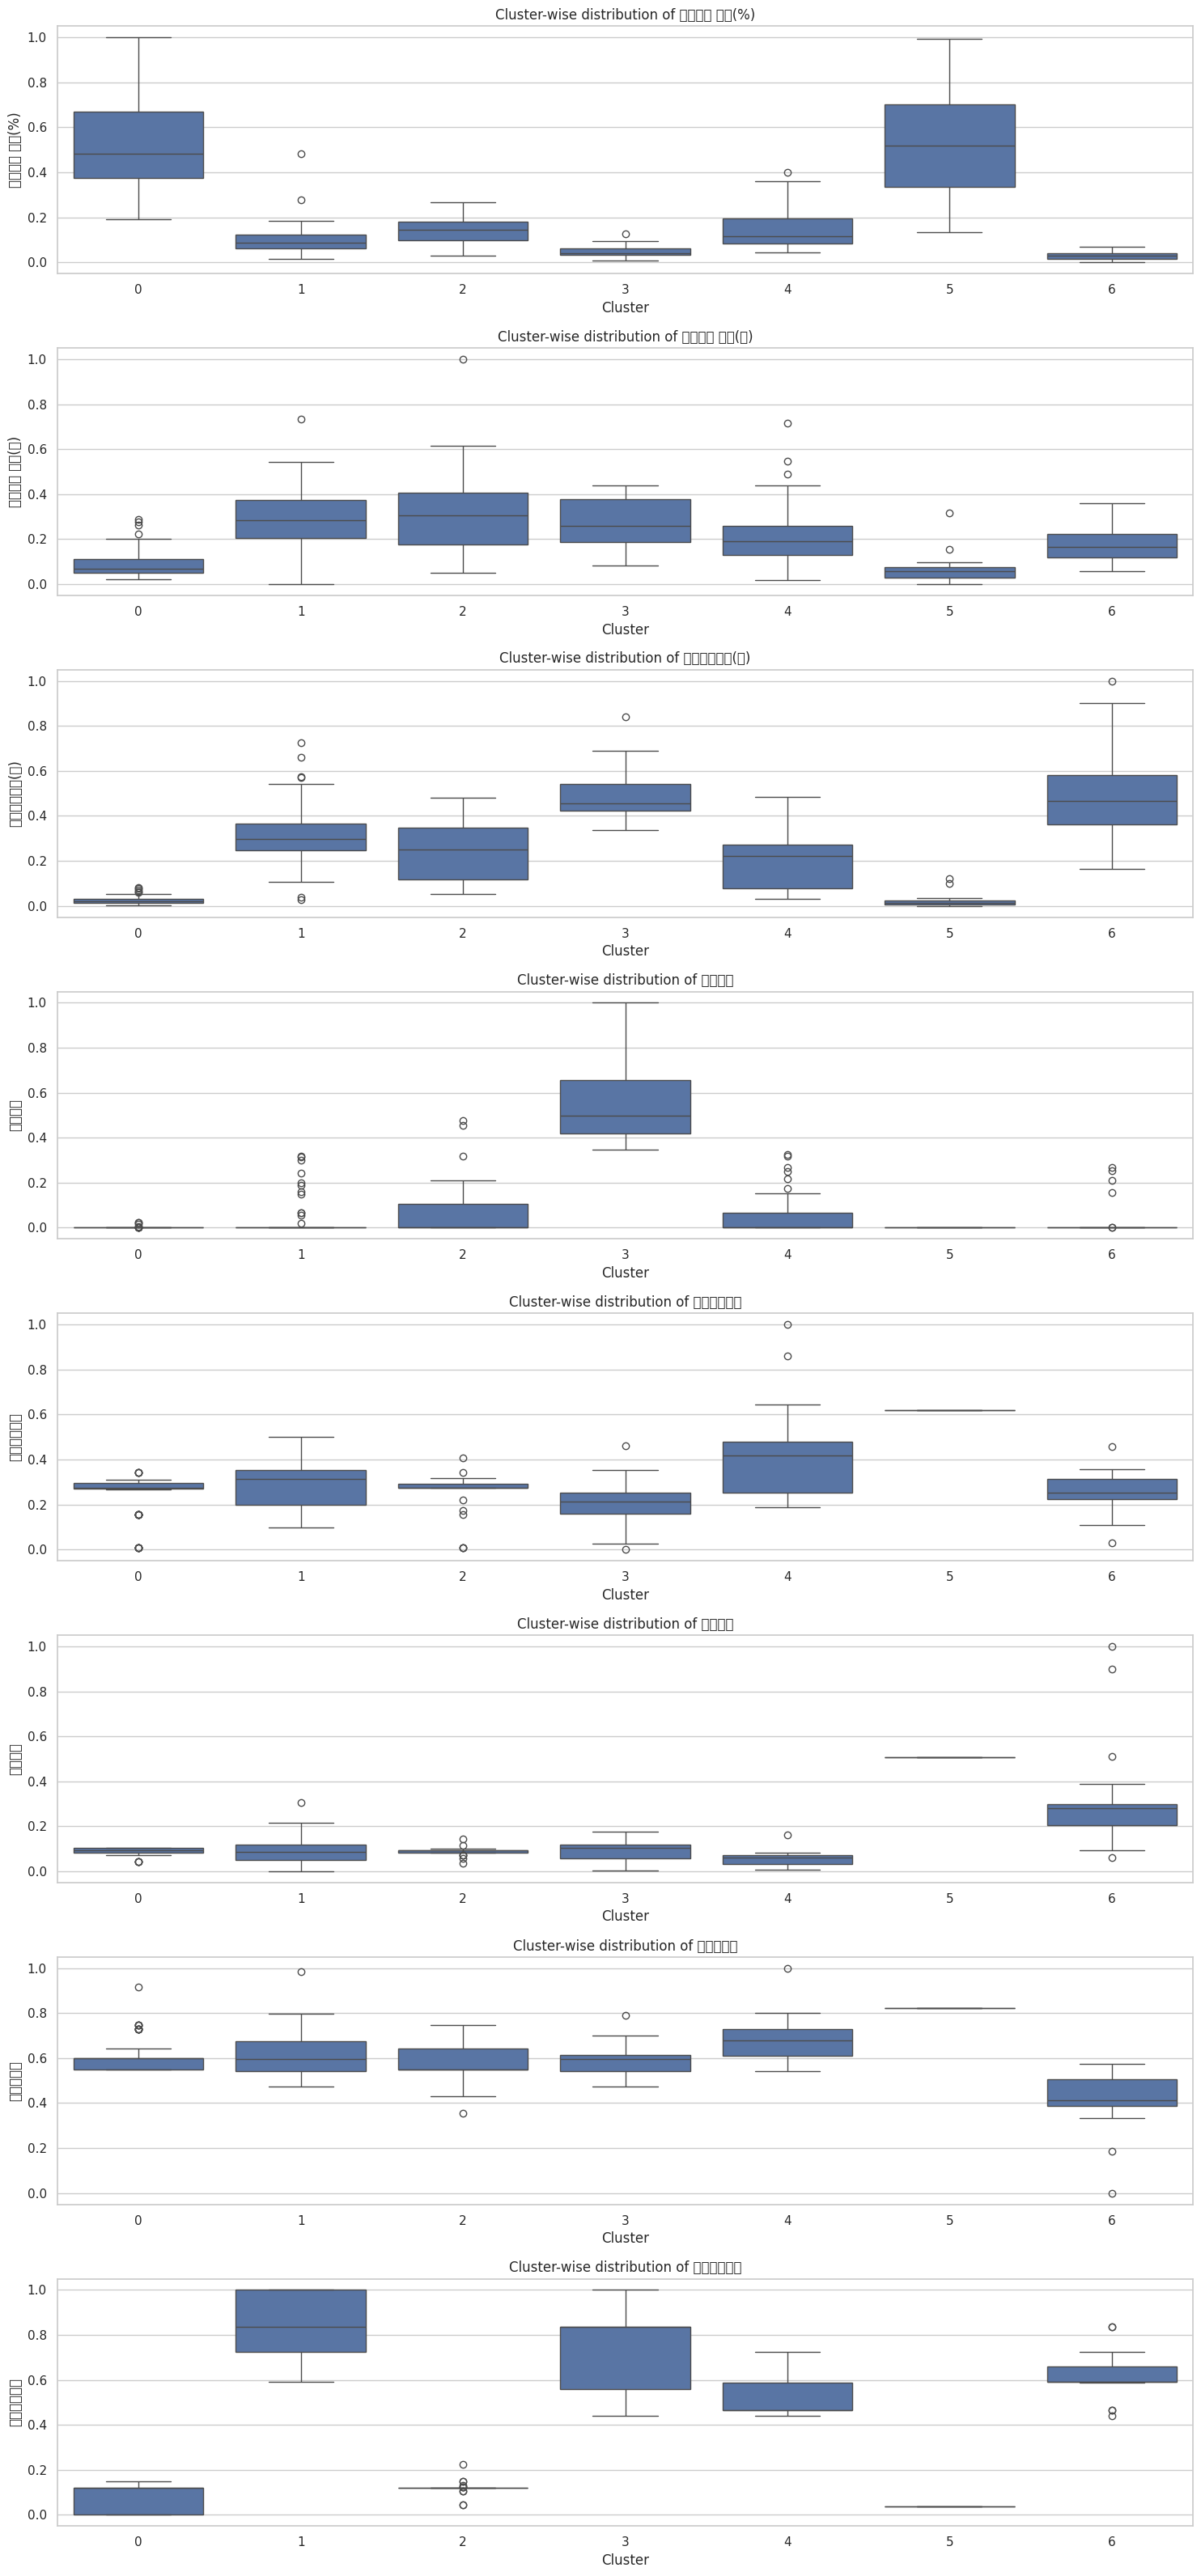

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 스타일 설정
sns.set(style='whitegrid')
plt.figure(figsize=(15, len(num_cols) * 4))

# 변수마다 boxplot 그리기
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(data=df, x='cluster', y=col)
    plt.title(f'Cluster-wise distribution of {col}')
    plt.xlabel('Cluster')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


##지역 작물 mapping

###새로운 작물 데이터 전처리

In [ ]:
crop=pd.read_csv('EcoCrop_전처리.csv')
crop.head()

,Unnamed: 0,학명,이름,최저기온,최고기온,일조량,평균강수량,생육개월
0,0,Abelmoschus esculentus,"abelmoskus, america-neri, bakhua mun, bamia, b...",20.0,30.0,11.0,900.0,3.8
1,1,Abelmoschus manihot,"neka (Simbo), bele (Fiji), pele (Tonga, Tuvalu...",22.0,30.0,15.0,1600.0,12.2
2,2,Abelmoschus moschatus,"abelmosk, musk mallow, mushkdan, muskdana, kas...",20.0,30.0,13.0,1200.0,0.0
3,3,Acacia auriculiformis,"Papuan wattle, auri, ear leaf acacia, tuhkehn ...",24.0,32.0,11.0,1850.0,7.0
4,4,Acacia farnesiana,"Ellington curse, klu, cassie, espino blanco, a...",20.0,32.0,11.0,900.0,5.0


In [ ]:
#결측값 평균대치
col=['TOPMN','TOPMX','ROPMN','ROPMX','GMIN','GMAX']
for c in col:
  crop[c] = crop[c].fillna(crop[c].mean())

In [ ]:
#일조시간전처리
crop['PHOTO'].value_counts()

,count
PHOTO,
short day (<12 hours),798
"short day (<12 hours), neutral day (12-14 hours), long day (>14 hours)",588
long day (>14 hours),227
"short day (<12 hours), neutral day (12-14 hours)",72
"neutral day (12-14 hours), long day (>14 hours)",15
neutral day (12-14 hours),10
not sensitive,8
"short day (<12 hours), long day (>14 hours)",2
"long day (>14 hours), neutral day (12-14 hours), short day (<12 hours)",2


In [ ]:
#일조시간 매핑
mapping = {
    'short day (<12 hours)': 11,
    'neutral day (12-14 hours)': 13,
    'long day (>14 hours)': 15,
    'short day (<12 hours), neutral day (12-14 hours)': 12,
    'neutral day (12-14 hours), long day (>14 hours)': 14,
    'short day (<12 hours), long day (>14 hours)': 13,
    'short day (<12 hours), neutral day (12-14 hours), long day (>14 hours)': 13,
    'long day (>14 hours), neutral day (12-14 hours), short day (<12 hours)': 13,
    'not sensitive': 13,  # 또는NONE으로 처리 가능
    None: 13
}

crop['일조량'] = crop['일조량'].replace(mapping)
crop['일조량'] = crop['일조량'].fillna(13)

In [ ]:
#컬럼명 변경
crop = crop.rename(columns={
    'ScientificName': '학명',
    'COMNAME': '이름',
    'TOPMN': '최저기온',
    'TOPMX': '최고기온',
    'ROPMN': '최소강수량',
    'ROPMX': '최대강수량',
    'PHOTO': '일조량',
    'GMIN': '최소생육기간',
    'GMAX': '최대생육기간',
    'LISPA': '생육기간유형'
})

In [ ]:
#평균강수량 컬럼 생성
crop['평균강수량'] = (crop['최소강수량'] + crop['최대강수량']) / 2
#생육일수 - 생육개월로 변경
crop['생육개월'] = ((crop['최소생육기간'] + crop['최대생육기간']) / 2 / 30).round(1)

In [ ]:
crop=crop.drop(columns=['최소강수량',	'최대강수량','최소생육기간','최대생육기간','생육기간유형'])

In [ ]:
crop.to_csv('EcoCrop_전처리.csv')

###벡터화/유클리드

In [ ]:
df=pd.read_csv('region_clustering2.csv').drop(columns='Unnamed: 0')
crop = pd.read_csv('EcoCrop_전처리.csv', encoding='utf-8').drop(columns='Unnamed: 0')#'windows-1252')

In [ ]:
crop.columns

Index(['학명', '이름', '최저기온', '최고기온', '일조량', '평균강수량', '생육개월'], dtype='object')

In [ ]:
# 작물 수를 줄인 전처리된 crop 데이터셋 생성 (학명 기준 한국 작물만)
korean_crop_scientific_names = [
    "Oryza sativa", "Hordeum vulgare", "Triticum aestivum", "Zea mays", "Sorghum bicolor",
    "Panicum miliaceum", "Glycine max", "Vigna angularis", "Vigna radiata", "Arachis hypogaea",
    "Brassica oleracea", "Raphanus sativus", "Daucus carota", "Spinacia oleracea", "Lactuca sativa",
    "Allium cepa", "Allium sativum", "Allium fistulosum", "Capsicum annuum",
    "Cucumis sativus", "Cucurbita pepo", "Solanum lycopersicum", "Ipomoea batatas",
    "Malus domestica", "Pyrus communis", "Prunus persica", "Vitis vinifera",
    "Diospyros kaki", "Citrullus lanatus", "Cucumis melo", "Fragaria × ananassa",
    "Prunus avium", "Vaccinium corymbosum", "Sesamum indicum", "Perilla frutescens",
    "Solanum tuberosum", "Zingiber officinale", "Panax ginseng", "Nelumbo nucifera", "Fagopyrum esculentum"
]

# crop_df에서 해당 학명만 필터링
crop = crop[crop['학명'].isin(korean_crop_scientific_names)]

# 중복 제거 후 필요한 컬럼 추출
cols_needed = ['학명', '이름', '최고기온', '최저기온', '평균강수량', '일조량', '생육개월']
crop = crop.drop_duplicates(subset='학명')[cols_needed].reset_index(drop=True)


In [ ]:
#작물 벡터화하는 과정

# 1. '작물' 열을 제외하고 벡터화할거 추출
columns_to_vectorize = crop[['최고기온', '최저기온', '평균강수량', '일조량','생육개월']]

# 2. 벡터화
vectorized_data = columns_to_vectorize.values

# 3. 데이터 프레임으로 변환
crop_vector_df = pd.DataFrame(vectorized_data, columns=['최고기온', '최저기온', '평균강수량', '일조량','생육개월'])

# 4. 원래 '작물' 열을 추가
crop_vector_df[['학명', '이름']] = crop[['학명', '이름']].values

# 결과 확인
crop_vector_df

,최고기온,최저기온,평균강수량,일조량,생육개월,학명,이름
0,25.0,12.0,475.0,13.0,4.3,Allium cepa,"onion, potato onion, shallot, echalote, oignon..."
1,25.0,12.0,1225.0,13.0,3.7,Allium fistulosum,"branching onion, Spanish onion, Japanese bunch..."
2,30.0,18.0,1175.0,15.0,3.5,Allium sativum,"garlic, cultivated garlic, ail, aglio, ajo, ka..."
3,30.0,17.0,925.0,12.0,4.0,Capsicum annuum,"sweet pepper, chili pepper, green pepper, laji..."
4,35.0,20.0,600.0,15.0,0.0,Citrullus lanatus,"watermelon, pastèque, stolovyj arbuz, melani, ..."
5,30.0,18.0,1150.0,13.0,2.8,Cucumis melo,"rock melon, sweet melon, cantaloupe melon, ati..."
6,32.0,18.0,1100.0,13.0,3.7,Cucumis sativus,"cucumber, gherkin, concombre, huanggua, kiukab..."
7,30.0,17.0,1050.0,13.0,2.3,Cucurbita pepo,"marrow, pumpkin, squash, bitter nut squash, ve..."
8,24.0,15.0,900.0,15.0,3.2,Daucus carota,"wild carrot, devil's plague, Queen Anne's-lace..."
9,31.0,20.0,1350.0,13.0,7.0,Diospyros kaki,"kaki, persimmon, Chinese persimmon, Japanese p..."


In [ ]:
crop_vector_df.columns = ['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)','생육개월','학명','이름']

In [ ]:
weather=pd.read_csv('weather_df.csv')
weather

,지점명,월,노장해발고도,평균기온,최고기온,최저기온,일최다강수량,1시간최다강수량,10분최다강수량,합계 일조시간,일조율,월평균강수량,월별강수량편차,시도시군구
0,강릉,1,27.12,1.916667,13.800000,-9.950000,19.916667,0.000000,0.000000,172.983333,56.405000,37.216667,105.0,강릉시
1,강릉,2,27.12,3.566667,16.800000,-7.450000,20.900000,0.000000,0.000000,170.333333,55.975000,32.000000,76.3,강릉시
2,강릉,3,27.12,9.600000,23.266667,-1.200000,30.866667,0.000000,0.000000,185.400000,49.986667,70.733333,113.2,강릉시
3,강릉,4,27.12,14.016667,28.116667,2.400000,32.183333,7.183333,2.983333,190.516667,48.165000,85.466667,118.0,강릉시
4,강릉,5,27.12,19.183333,33.200000,7.700000,38.700000,11.283333,3.483333,200.866667,45.916667,86.216667,158.4,강릉시
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,함양군,8,152.07,25.883333,35.950000,16.383333,102.116667,27.983333,11.716667,131.866667,31.540000,314.800000,530.1,함양군
1064,함양군,9,152.07,20.700000,31.016667,9.650000,63.133333,21.450000,8.150000,108.616667,29.153333,181.083333,243.4,함양군
1065,함양군,10,152.07,13.583333,28.033333,0.216667,67.600000,11.450000,3.850000,170.650000,48.745000,99.133333,257.6,함양군
1066,함양군,11,152.07,7.716667,23.733333,-4.800000,16.483333,0.000000,0.000000,144.816667,46.810000,33.866667,35.1,함양군


In [ ]:
#기상청 데이터 벡터화하는 과정

# 1. '작물' 열을 제외하고 벡터화할거 추출
columns_to_vectorize = weather[['최고기온', '최저기온', '월평균강수량','합계 일조시간']].copy()
columns_to_vectorize['합계 일조시간'] = weather['합계 일조시간'] / 30
columns_to_vectorize.columns = ['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']

# 2. 벡터화
vectorized_data = columns_to_vectorize.values

# 3. 데이터 프레임으로 변환
weather_vector_df = pd.DataFrame(
    vectorized_data,
    columns=['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']
)

# 4. 원래 '작물' 열을 추가
weather_vector_df['지점명'] = weather['지점명'].values
weather_vector_df['월'] = weather['월'].values
# 결과 확인
weather_vector_df

,최고기온,최저기온,평균강수량(mm),일조량(hr),지점명,월
0,13.800000,-9.950000,37.216667,5.766111,강릉,1
1,16.800000,-7.450000,32.000000,5.677778,강릉,2
2,23.266667,-1.200000,70.733333,6.180000,강릉,3
3,28.116667,2.400000,85.466667,6.350556,강릉,4
4,33.200000,7.700000,86.216667,6.695556,강릉,5
...,...,...,...,...,...,...
1063,35.950000,16.383333,314.800000,4.395556,함양군,8
1064,31.016667,9.650000,181.083333,3.620556,함양군,9
1065,28.033333,0.216667,99.133333,5.688333,함양군,10
1066,23.733333,-4.800000,33.866667,4.827222,함양군,11


In [ ]:
#중심이동만 하는 간소화된 코드

from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
import pandas as pd
import numpy as np

# 데이터 정규화 (Min-Max Scaler)
scaler = MinMaxScaler()
crop_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']] = scaler.fit_transform(
    crop_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']]
)
weather_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']] = scaler.transform(
    weather_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']]
)

# 중심 이동: 중앙값 기준으로 데이터 이동
crop_centered_df = crop_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']] - \
                   crop_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']].median()
weather_centered_df = weather_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']] - \
                      weather_vector_df[['최고기온', '최저기온', '평균강수량(mm)', '일조량(hr)']].median()

# 중심 이동된 유클리드 거리 계산
for _, crop_row in crop_vector_df.iterrows():
    crop_name = crop_row['학명']
    crop_vector_centered = crop_centered_df.loc[crop_row.name].values

    centered_euclidean_distances = []

    for _, weather_row in weather_vector_df.iterrows():
        weather_vector_centered = weather_centered_df.loc[weather_row.name].values

        # 중심 이동된 유클리드 거리 계산
        centered_euclidean_dist = euclidean(crop_vector_centered, weather_vector_centered)
        centered_euclidean_distances.append(centered_euclidean_dist)

    # 계산 결과를 weather_vector_df에 추가
    weather_vector_df[f'{crop_name}_중심이동_유클리드거리'] = centered_euclidean_distances


###모든 작물에 대해서 진행(중심이동 유클리드를 이용하여 적용!)

In [ ]:
crop_vector_df

,최고기온,최저기온,평균강수량(mm),일조량(hr),생육개월,학명,이름
0,0.3125,0.35,0.025316,0.50,4.3,Allium cepa,"onion, potato onion, shallot, echalote, oignon..."
1,0.3125,0.35,0.405063,0.50,3.7,Allium fistulosum,"branching onion, Spanish onion, Japanese bunch..."
2,0.6250,0.65,0.379747,1.00,3.5,Allium sativum,"garlic, cultivated garlic, ail, aglio, ajo, ka..."
3,0.6250,0.60,0.253165,0.25,4.0,Capsicum annuum,"sweet pepper, chili pepper, green pepper, laji..."
4,0.9375,0.75,0.088608,1.00,0.0,Citrullus lanatus,"watermelon, pastèque, stolovyj arbuz, melani, ..."
5,0.6250,0.65,0.367089,0.50,2.8,Cucumis melo,"rock melon, sweet melon, cantaloupe melon, ati..."
6,0.7500,0.65,0.341772,0.50,3.7,Cucumis sativus,"cucumber, gherkin, concombre, huanggua, kiukab..."
7,0.6250,0.60,0.316456,0.50,2.3,Cucurbita pepo,"marrow, pumpkin, squash, bitter nut squash, ve..."
8,0.2500,0.50,0.240506,1.00,3.2,Daucus carota,"wild carrot, devil's plague, Queen Anne's-lace..."
9,0.6875,0.75,0.468354,0.50,7.0,Diospyros kaki,"kaki, persimmon, Chinese persimmon, Japanese p..."


In [ ]:
### 이 코드를 쓰는 이유
### 작물별로 생육기간이 다르기에 그거 연속된 값의 평균을 구함으로써 어떤 연속된 달들이 최적일지 선정하기 위해!
### 이때 1,2,3,4의 경우에는 그냥 되지만 11,12,1도 순환되는 값이기에 이를 처리하기 위한 롤링 처리!

# 생육개월 정수로 반올림
crop_vector_df['생육개월'] = crop_vector_df['생육개월'].round().astype(int)
# '학명'과 '생육개월' 컬럼을 딕셔너리로 변환
crop_periods = crop_vector_df.set_index('학명')['생육개월'].to_dict()

# 연속된 n개월 동안 유사도 계산 및 월 정보 추가 (순환 처리)
def calculate_rolling_similarity_with_wrap(df, column, period):
    # 월 정렬
    df = df.sort_values(by="월")

    # 월 순환 처리를 위해 데이터를 이어붙임
    df_extended = pd.concat([df, df], ignore_index=True)

    # n개월 롤링 평균 계산
    rolling_means = []
    rolling_months = []

    for i in range(len(df)):
        # 연속된 n개월을 순환적으로 계산
        window = df_extended.iloc[i:i+period]
        if len(window) == period:
            rolling_means.append(window[column].mean())
            rolling_months.append(list(window["월"]))
        else:
            rolling_means.append(None)
            rolling_months.append(None)

    # 원래 데이터에 연속된 n개월 유사도 및 월 리스트 추가
    df["연속_n개월_유사도"] = rolling_means
    df["연속_n개월_월들"] = rolling_months
    return df[["지점명", "월", "연속_n개월_유사도", "연속_n개월_월들"]]

# 모든 작물의 생육 기간에 따라 계산
results = []

for crop, period in crop_periods.items():
    column_name = f"{crop}_중심이동_유클리드거리"

    # "작물"별로 연속된 n개월 유사도 계산
    result = weather_vector_df.groupby("지점명").apply(
        calculate_rolling_similarity_with_wrap, column=column_name, period=period
    )
    result["작물"] = crop  # 작물 이름 추가
    results.append(result)

# 모든 결과를 병합
final_result = pd.concat(results, ignore_index=True)

# 상위 10개의 유사도 결과를 작물별로 추출
top_results = final_result[final_result["연속_n개월_유사도"].notnull()]
top_results = top_results.groupby("작물").apply(lambda x: x.nsmallest(10, "연속_n개월_유사도")).reset_index(drop=True)


<ipython-input-18-b7257b539877>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = weather_vector_df.groupby("지점명").apply(
<ipython-input-18-b7257b539877>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = weather_vector_df.groupby("지점명").apply(
<ipython-input-18-b7257b539877>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in

In [ ]:
top_results.to_csv('매핑_result.csv')

In [ ]:
top_results

,지점명,월,연속_n개월_유사도,연속_n개월_월들,작물
0,양산시,11,0.400824,"[11, 12, 1, 2]",Allium cepa
1,양산시,12,0.404672,"[12, 1, 2, 3]",Allium cepa
2,광양시,11,0.419334,"[11, 12, 1, 2]",Allium cepa
3,경주시,11,0.422289,"[11, 12, 1, 2]",Allium cepa
4,울산,11,0.430090,"[11, 12, 1, 2]",Allium cepa
...,...,...,...,...,...
335,고흥,2,0.839149,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",Zingiber officinale
336,완도,9,0.841975,"[9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]",Zingiber officinale
337,고흥,9,0.842260,"[9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]",Zingiber officinale
338,거제,2,0.842519,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",Zingiber officinale


##지역이랑 매핑

In [ ]:
df=pd.read_csv("/content/매핑_result.csv").drop(columns='Unnamed: 0')
df

,지점명,월,연속_n개월_유사도,연속_n개월_월들,작물
0,양산시,11,0.400824,"[11, 12, 1, 2]",Allium cepa
1,양산시,12,0.404672,"[12, 1, 2, 3]",Allium cepa
2,광양시,11,0.419334,"[11, 12, 1, 2]",Allium cepa
3,경주시,11,0.422289,"[11, 12, 1, 2]",Allium cepa
4,울산,11,0.430090,"[11, 12, 1, 2]",Allium cepa
...,...,...,...,...,...
335,고흥,2,0.839149,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",Zingiber officinale
336,완도,9,0.841975,"[9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]",Zingiber officinale
337,고흥,9,0.842260,"[9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7]",Zingiber officinale
338,거제,2,0.842519,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",Zingiber officinale


In [ ]:
final_keyword_map = {
    "강진": "전라남도", "거제": "경상남도", "거창": "경상남도", "고창": "전라북도",
    "고흥": "전라남도", "남해": "경상남도", "보은": "충청북도", "순창": "전라북도",
    "영주": "경상북도", "울진": "경상북도", "원주": "강원특별자치도", "의령": "경상남도",
    "인제": "강원특별자치도", "임실": "전라북도", "정선": "강원특별자치도", "창원": "경상남도",
    "천안": "충청남도", "철원": "강원특별자치도", "추풍령": "충청북도", "통영": "경상남도",
    "함양": "경상남도", "합천": "경상남도", "해남": "전라남도",
    "양산": "경상남도", "진주": "경상남도", "경주": "경상북도", "대관령": "강원특별자치도",
    "진도": "전라남도", "동해": "강원특별자치도", "속초": "강원특별자치도", "광양": "전라남도",
    "울산": "울산광역시", "김해": "경상남도", "구미": "경상북도", "포항": "경상북도",
    "안동": "경상북도", "영덕": "경상북도", "영천": "경상북도", "문경": "경상북도",
    "상주": "경상북도", "영월": "강원특별자치도", "이천": "경기도", "밀양": "경상남도",
    "가평": "경기도", "강화": "인천광역시", "고성": "강원특별자치도", "고양": "경기도",
    "공주": "충청남도", "과천": "경기도", "광명": "경기도", "광주": "광주광역시",
    "구리": "경기도", "군포": "경기도", "금산": "충청남도", "김포": "경기도",
    "나주": "전라남도", "논산": "충청남도", "단양": "충청북도", "당진": "충청남도",
    "보성": "전라남도", "사천": "경상남도", "산청": "경상남도", "서귀포": "제주특별자치도",
    "서산": "충청남도", "서천": "충청남도", "순천": "전라남도", "시흥": "경기도",
    "아산": "충청남도", "안성": "경기도", "안양": "경기도", "여수": "전라남도",
    "여주": "경기도", "연천": "경기도", "영동": "충청북도", "예산": "충청남도",
    "옥천": "충청북도", "완도": "전라남도", "용인": "경기도", "의왕": "경기도",
    "의정부": "경기도", "장수": "전라북도", "장흥": "전라남도", "전주": "전라북도",
    "정읍": "전라북도", "제천": "충청북도", "진안": "전라북도", "청양": "충청남도",
    "청주": "충청북도", "춘천": "강원특별자치도", "충주": "충청북도", "태백": "강원특별자치도",
    "태안": "충청남도", "평창": "강원특별자치도", "포천": "경기도", "하남": "경기도",
    "화성": "경기도", "홍성": "충청남도", "홍천": "강원특별자치도"
}

# 지점명에서 시군명 추출 후 시도명 붙이기
df['시도'] = df['지점명'].apply(lambda x: final_keyword_map.get(x.replace("시", "").replace("군", "").replace("구", ""), "시도미상"))
df['지점명'] = df['시도'] + " " + df['지점명']

In [ ]:
# 시도미상으로 매핑된 행 확인
unknown_rows = df[df['시도'] == "시도미상"]
print(unknown_rows[['지점명']].drop_duplicates())
print(f"\n총 시도미상 개수: {len(unknown_rows)}개")

          지점명
21    시도미상 세종
26   시도미상 동두천
36    시도미상 봉화
83    시도미상 부산
86    시도미상 인천
106   시도미상 구미
314   시도미상 제주

총 시도미상 개수: 31개


In [ ]:
import re

# 예외처리 맵
exception_map = {
    "세종": "세종특별자치시",
    "동두천": "경기도",
    "봉화": "경상북도",
    "부산": "부산광역시",
    "인천": "인천광역시",
    "구미": "경상북도",
    "제주": "제주특별자치도"
}

# 전체 키워드 맵
keyword_map = {**final_keyword_map, **exception_map}

# 시도 추정 함수
def map_to_sido(name):
    name_clean = re.sub(r'^(시도미상\s*)?', '', name)
    key = re.sub(r'(시|군|구)$', '', name_clean.split()[-1])  # '양산시' → '양산'
    return keyword_map.get(key, "시도미상")

# 이미 '시도 지점명' 형식인지 확인 후 새로 결합
def clean_and_combine(row):
    name = row['지점명']
    if bool(re.match(r'^(서울|부산|대구|인천|광주|대전|울산|세종|경기도|강원|충청|전라|경상|제주)', name)):
        return name  # 이미 시도 들어간 경우
    name_clean = re.sub(r'^(시도미상\s*)?', '', name)
    return row['시도'] + " " + name_clean

# 시도 추정 및 적용
df['시도'] = df['지점명'].apply(map_to_sido)
df['지점명'] = df.apply(clean_and_combine, axis=1)


In [ ]:
# 시도미상으로 매핑된 행 확인
unknown_rows = df[df['시도'] == "시도미상"]
print(unknown_rows[['지점명']].drop_duplicates())
print(f"\n총 시도미상 개수: {len(unknown_rows)}개")

Empty DataFrame
Columns: [지점명]
Index: []

총 시도미상 개수: 0개


In [ ]:
df.to_csv("시도명_전처리완_매핑result.csv")

In [ ]:
# 유클리드 거리 기반 유사도라면, 낮을수록 더 유사하므로 오름차순 정렬
top_crop_by_location_euclidean = df.sort_values("연속_n개월_유사도", ascending=True) \
                                   .drop_duplicates(subset=["지점명"]) \
                                   [["지점명", "시도", "작물", "연속_n개월_유사도"]]
top_crop_by_location_euclidean

,지점명,시도,작물,연속_n개월_유사도
260,경상남도 거제,경상남도,Spinacia oleracea,0.174884
261,경상남도 양산시,경상남도,Spinacia oleracea,0.176015
262,경상남도 통영,경상남도,Spinacia oleracea,0.179344
263,전라남도 광양시,전라남도,Spinacia oleracea,0.192413
264,전라남도 완도,전라남도,Spinacia oleracea,0.196467
...,...,...,...,...
329,전라북도 임실,전라북도,Zea mays,0.535561
297,충청남도 금산,충청남도,Vigna angularis,0.537838
314,제주특별자치도 제주,제주특별자치도,Vitis vinifera,0.570598
183,전라북도 순창군,전라북도,Perilla frutescens,0.783326


In [ ]:
# 시도별로 유클리드 거리가 가장 낮은 (즉, 유사도가 가장 높은) 지점-작물 하나만 남기기
top_crop_by_sido = top_crop_by_location_euclidean.sort_values("연속_n개월_유사도", ascending=True) \
                                                 .drop_duplicates(subset=["지점명"]) \
                                                 [["시도", "지점명", "작물", "연속_n개월_유사도"]]

# 결과 출력
top_crop_by_sido

,시도,지점명,작물,연속_n개월_유사도
260,경상남도,경상남도 거제,Spinacia oleracea,0.174884
261,경상남도,경상남도 양산시,Spinacia oleracea,0.176015
262,경상남도,경상남도 통영,Spinacia oleracea,0.179344
263,전라남도,전라남도 광양시,Spinacia oleracea,0.192413
264,전라남도,전라남도 완도,Spinacia oleracea,0.196467
...,...,...,...,...
329,전라북도,전라북도 임실,Zea mays,0.535561
297,충청남도,충청남도 금산,Vigna angularis,0.537838
314,제주특별자치도,제주특별자치도 제주,Vitis vinifera,0.570598
183,전라북도,전라북도 순창군,Perilla frutescens,0.783326


In [ ]:
# 작물명 기준으로 지점명들을 리스트로 묶어서 딕셔너리 생성
crop_to_locations = top_crop_by_sido.groupby("작물")["지점명"].apply(list).to_dict()

# 결과 일부 확인
dict(list(crop_to_locations.items())[:5])  # 앞에서 5개만 미리보기

{'Allium fistulosum': ['경상남도 김해시'],
 'Allium sativum': ['경상남도 진주', '세종특별자치시 세종', '경기도 동두천', '강원특별자치도 철원'],
 'Arachis hypogaea': ['강원특별자치도 대관령'],
 'Capsicum annuum': ['전라남도 진도'],
 'Cucumis melo': ['전라남도 순천', '전라남도 고흥', '경상남도 의령군', '강원특별자치도 정선군', '전라남도 진도군']}

In [ ]:
import re

df=pd.read_csv("/content/region_clustering2.csv").drop(columns='Unnamed: 0')
# 클러스터 딕셔너리 생성
cluster_groups = df.groupby('region_cluster_id')['지점명'].apply(list)
clusters = {cluster: locations for cluster, locations in cluster_groups.items()}

# 작물 데이터 딕셔너리 생성
# crop_to_locations

# 교집합 비율 계산 결과 저장
results = []

# 모든 클러스터와 작물의 교집합 비율 계산
for cluster_id, locations in clusters.items():
    for crop, crop_locations in crop_to_locations.items():
        # 교집합에 해당되는 지역 확인
        matching_locations = [loc for loc in locations for crop_loc in crop_locations if re.search(re.escape(crop_loc), loc)]
        overlap = len(matching_locations)
        ratio = overlap / len(locations) if locations else 0  # 교집합 비율 계산
        results.append((cluster_id, crop, overlap, ratio, matching_locations))

# 결과 출력
for cluster_id, crop, overlap, ratio, matching_locations in sorted(results, key=lambda x: (x[0], -x[2], -x[3])):
  if ratio>0:
    print(f"클러스터 {cluster_id} - 작물 {crop}: 교집합 크기 {overlap}, 교집합 비율 {ratio:.2f}")


클러스터 2 - 작물 Spinacia oleracea: 교집합 크기 1, 교집합 비율 0.06
클러스터 6 - 작물 Diospyros kaki: 교집합 크기 1, 교집합 비율 0.50
클러스터 13 - 작물 Allium sativum: 교집합 크기 1, 교집합 비율 1.00
클러스터 15 - 작물 Allium sativum: 교집합 크기 1, 교집합 비율 0.06
클러스터 16 - 작물 Allium sativum: 교집합 크기 1, 교집합 비율 0.07
클러스터 16 - 작물 Cucumis melo: 교집합 크기 1, 교집합 비율 0.07
클러스터 16 - 작물 Cucumis sativus: 교집합 크기 1, 교집합 비율 0.07
클러스터 16 - 작물 Cucurbita pepo: 교집합 크기 1, 교집합 비율 0.07
클러스터 16 - 작물 Fagopyrum esculentum: 교집합 크기 1, 교집합 비율 0.07
클러스터 16 - 작물 Glycine max: 교집합 크기 1, 교집합 비율 0.07
클러스터 18 - 작물 Fagopyrum esculentum: 교집합 크기 2, 교집합 비율 1.00
클러스터 19 - 작물 Raphanus sativus: 교집합 크기 1, 교집합 비율 1.00
클러스터 20 - 작물 Raphanus sativus: 교집합 크기 1, 교집합 비율 1.00
클러스터 23 - 작물 Vigna angularis: 교집합 크기 1, 교집합 비율 0.50
클러스터 24 - 작물 Daucus carota: 교집합 크기 1, 교집합 비율 0.25
클러스터 25 - 작물 Prunus persica: 교집합 크기 2, 교집합 비율 0.17
클러스터 25 - 작물 Daucus carota: 교집합 크기 1, 교집합 비율 0.08
클러스터 26 - 작물 Perilla frutescens: 교집합 크기 1, 교집합 비율 0.25
클러스터 27 - 작물 Perilla frutescens: 교집합 크기 1, 교집합 비율 0.17
클러스터 27 - 작

##cluster 별 지역 df 생성

In [ ]:
cluster_groups#[cluster_groups['cluster']==0]['지점명']

,지점명
region_cluster_id,
1,"[서울특별시 종로구, 서울특별시 중구, 서울특별시 용산구, 서울특별시 성동구, 서울..."
2,"[부산광역시 중구, 부산광역시 서구, 부산광역시 동구, 부산광역시 영도구, 부산광역..."
3,"[대구광역시 중구, 대구광역시 서구, 대구광역시 남구, 대구광역시 북구, 대구광역시..."
4,"[대구광역시 동구, 대구광역시 달성군, 대구광역시 군위군]"
5,"[인천광역시 중구, 인천광역시 동구, 인천광역시 연수구, 인천광역시 남동구, 인천광..."
6,"[인천광역시 강화군, 인천광역시 옹진군]"
7,"[광주광역시 동구, 광주광역시 서구, 광주광역시 남구, 광주광역시 북구]"
8,[광주광역시 광산구]
9,"[대전광역시 동구, 대전광역시 유성구]"


In [ ]:
# Converting cluster_groups back into a DataFrame with 'cluster' and '지점명' columns
df_restructured = cluster_groups.reset_index()

# Ensuring the '지점명' column is formatted as strings
df_restructured['지점명'] = df_restructured['지점명'].apply(lambda x: ', '.join(x))

df_restructured

,region_cluster_id,지점명
0,1,"서울특별시 종로구, 서울특별시 중구, 서울특별시 용산구, 서울특별시 성동구, 서울특..."
1,2,"부산광역시 중구, 부산광역시 서구, 부산광역시 동구, 부산광역시 영도구, 부산광역시..."
2,3,"대구광역시 중구, 대구광역시 서구, 대구광역시 남구, 대구광역시 북구, 대구광역시 ..."
3,4,"대구광역시 동구, 대구광역시 달성군, 대구광역시 군위군"
4,5,"인천광역시 중구, 인천광역시 동구, 인천광역시 연수구, 인천광역시 남동구, 인천광역..."
5,6,"인천광역시 강화군, 인천광역시 옹진군"
6,7,"광주광역시 동구, 광주광역시 서구, 광주광역시 남구, 광주광역시 북구"
7,8,광주광역시 광산구
8,9,"대전광역시 동구, 대전광역시 유성구"
9,10,"대전광역시 중구, 대전광역시 서구, 대전광역시 대덕구"


In [ ]:
# 클러스터별 추천 작물을 ratio 기준으로 다시 계산
best_crop_by_cluster = {}
for cluster_id, crop, overlap, ratio, matching_locations in results:
    if ratio == 0:
        continue
    if cluster_id not in best_crop_by_cluster or best_crop_by_cluster[cluster_id][1] < ratio:
        best_crop_by_cluster[cluster_id] = (crop, ratio)

# region_clustering2.csv 다시 로드 및 클러스터 그룹 재구조화
df = pd.read_csv("/content/region_clustering2.csv").drop(columns='Unnamed: 0')
cluster_groups = df.groupby('region_cluster_id')['지점명'].apply(list)
df_restructured = cluster_groups.reset_index()
df_restructured['지점명'] = df_restructured['지점명'].apply(lambda x: ', '.join(x))

# 추천 작물 영어/한글 컬럼 추가
crop_names_en = []
crop_names_ko = []

# 작물 번역 딕셔너리
translation_dict = {
    "Allium sativum": "마늘",
    "Allium fistulosum": "대파",
    "Capsicum annuum": "고추",
    "Cucumis melo": "멜론",
    "Cucumis sativus": "오이",
    "Cucurbita pepo": "호박",
    "Daucus carota": "당근",
    "Diospyros kaki": "감",
    "Fagopyrum esculentum": "메밀",
    "Glycine max": "콩",
    "Perilla frutescens": "들깨",
    "Prunus persica": "복숭아",
    "Raphanus sativus": "무",
    "Sesamum indicum": "참깨",
    "Solanum tuberosum": "감자",
    "Spinacia oleracea": "시금치",
    "Triticum aestivum": "밀",
    "Vigna angularis": "팥",
    "Vitis vinifera": "포도",
    "Zea mays": "옥수수"
}

for cluster_id in df_restructured['region_cluster_id']:
    crop_en = best_crop_by_cluster.get(cluster_id, ("없음", 0))[0]
    crop_ko = translation_dict.get(crop_en, "없음") if crop_en != "없음" else "없음"
    crop_names_en.append(crop_en)
    crop_names_ko.append(crop_ko)

df_restructured['추천작물(영문)'] = crop_names_en
df_restructured['추천작물(한글)'] = crop_names_ko

df_restructured

,region_cluster_id,지점명,추천작물(영문),추천작물(한글)
0,1,"서울특별시 종로구, 서울특별시 중구, 서울특별시 용산구, 서울특별시 성동구, 서울특...",없음,없음
1,2,"부산광역시 중구, 부산광역시 서구, 부산광역시 동구, 부산광역시 영도구, 부산광역시...",Spinacia oleracea,시금치
2,3,"대구광역시 중구, 대구광역시 서구, 대구광역시 남구, 대구광역시 북구, 대구광역시 ...",없음,없음
3,4,"대구광역시 동구, 대구광역시 달성군, 대구광역시 군위군",없음,없음
4,5,"인천광역시 중구, 인천광역시 동구, 인천광역시 연수구, 인천광역시 남동구, 인천광역...",없음,없음
5,6,"인천광역시 강화군, 인천광역시 옹진군",Diospyros kaki,감
6,7,"광주광역시 동구, 광주광역시 서구, 광주광역시 남구, 광주광역시 북구",없음,없음
7,8,광주광역시 광산구,없음,없음
8,9,"대전광역시 동구, 대전광역시 유성구",없음,없음
9,10,"대전광역시 중구, 대전광역시 서구, 대전광역시 대덕구",없음,없음


In [ ]:
# 추천작물(한글)이 '없음'인 행 제거
df_filtered = df_restructured[df_restructured['추천작물(한글)'] != "없음"].reset_index(drop=True)

df_filtered

,region_cluster_id,지점명,추천작물(영문),추천작물(한글)
0,2,"부산광역시 중구, 부산광역시 서구, 부산광역시 동구, 부산광역시 영도구, 부산광역시...",Spinacia oleracea,시금치
1,6,"인천광역시 강화군, 인천광역시 옹진군",Diospyros kaki,감
2,13,세종특별자치시 세종특별자치시,Allium sativum,마늘
3,15,"경기도 평택시, 경기도 동두천시, 경기도 고양시 덕양구, 경기도 남양주시, 경기도 ...",Allium sativum,마늘
4,16,"강원특별자치도 춘천시, 강원특별자치도 원주시, 강원특별자치도 태백시, 강원특별자치도...",Allium sativum,마늘
5,18,"강원특별자치도 동해시, 강원특별자치도 속초시",Fagopyrum esculentum,메밀
6,19,충청북도 충주시,Raphanus sativus,무
7,20,충청북도 제천시,Raphanus sativus,무
8,23,"충청남도 영동군, 충청남도 금산군",Vigna angularis,팥
9,24,"충청남도 괴산군, 충청남도 단양군, 충청남도 공주시, 충청남도 서산시",Daucus carota,당근


In [ ]:
df_filtered['추천작물(한글)'].unique()

array(['시금치', '감', '마늘', '메밀', '무', '팥', '당근', '복숭아', '들깨', '호박', '밀',
       '포도', '감자'], dtype=object)

In [ ]:
df_filtered.to_csv('cluster_mapping_최종.csv')